# dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torch import nn, optim
import numpy as np
from typing import Tuple, Dict, List
from tqdm.auto import tqdm
import timeit
import os
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [2]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)
df = df.sample(frac=1).reset_index()
df

,index,0,1
0,1627,the problem is the needlessly poor quality of ...,0
1,1678,a feeble tootsie knockoff,0
2,2627,"the bottom line , at least in my opinion , is ...",0
3,5892,would benigni 's italian pinocchio have been a...,0
4,3301,"van wilder has a built in audience , but only ...",0
...,...,...,...
6915,6439,it all starts to smack of a hallmark hall of f...,0
6916,2436,"but windtalkers does n't beat that one , either",0
6917,3990,the rules of attraction gets us too drunk on t...,0
6918,574,there 's a sheer unbridled delight in the way ...,1


In [3]:
df.columns

Index(['index', 0, 1], dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6920 entries, 0 to 6919
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   6920 non-null   int64 
 1   0       6920 non-null   object
 2   1       6920 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 162.3+ KB


In [5]:
df.describe()

,index,1
count,6920.000000,6920.000000
mean,3459.500000,0.521676
std,1997.776264,0.499566
min,0.000000,0.000000
25%,1729.750000,0.000000
50%,3459.500000,1.000000
75%,5189.250000,1.000000
max,6919.000000,1.000000


In [6]:
df[1].value_counts()

1    3610
0    3310
Name: 1, dtype: int64

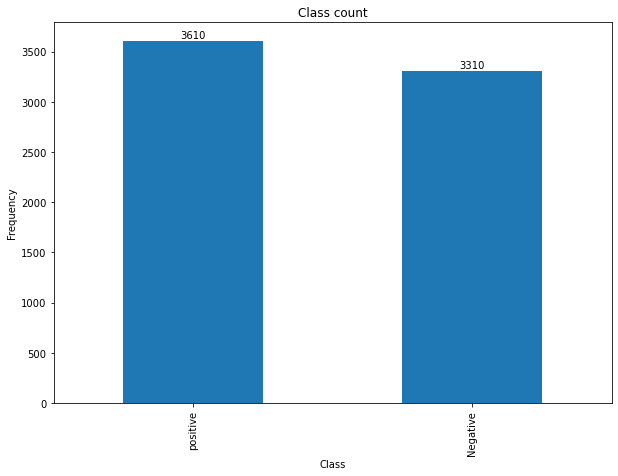

In [7]:
frequencies = list(df[1].value_counts())
# In my original code I create a series and run on that,
# so for consistency I create a series from the list.
freq_series = pd.Series(frequencies)

x_labels = ['positive','Negative']

# Plot the figure.
plt.figure(figsize=(10, 7))
ax = freq_series.plot(kind="bar")
ax.set_title("Class count")
ax.set_xlabel("Class")
ax.set_ylabel("Frequency")
ax.set_xticklabels(x_labels)

rects = ax.patches

# Make some labels.
labels = frequencies

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )

plt.show()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [10]:
# apply text tokenizer
tokenized=df[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized

0       [101, 1996, 3291, 2003, 1996, 17044, 14540, 21...
1       [101, 1037, 7408, 3468, 2205, 3215, 2666, 7324...
2       [101, 1996, 3953, 2240, 1010, 2012, 2560, 1999...
3       [101, 2052, 28378, 2072, 1005, 1055, 3059, 923...
4       [101, 3158, 18463, 2038, 1037, 2328, 1999, 437...
                              ...                        
6915    [101, 2009, 2035, 4627, 2000, 21526, 1997, 103...
6916    [101, 2021, 3612, 28014, 2545, 2515, 1050, 100...
6917    [101, 1996, 3513, 1997, 8432, 4152, 2149, 2205...
6918    [101, 2045, 1005, 1055, 1037, 11591, 4895, 237...
6919    [101, 2054, 1048, 15185, 10424, 7416, 25269, 2...
Name: 0, Length: 6920, dtype: object

In [11]:
# max len tokenized
max_len = max(len(i) for i in tokenized)
max_len

67

In [12]:
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [13]:
padded.shape

(6920, 67)

In [14]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(6920, 67)

In [15]:
labels = np.array(df[1])
labels.shape

(6920,)

In [16]:
# train-test split
train_size = int(len(attention_mask)*0.7)
padded_train = padded[:train_size]
padded_val = padded[train_size:]
attention_mask_train = attention_mask[:train_size]
attention_mask_val = attention_mask[train_size:]
labels_train = labels[:train_size]
labels_val = labels[train_size:]
len(padded_train), len(padded_val), len(attention_mask_train), len(attention_mask_val)

(4844, 2076, 4844, 2076)

In [17]:
len(labels_train), len(labels_val)

(4844, 2076)

In [18]:
# custom dataset
class TokenDataset(Dataset):
    def __init__(self,padded, attention_mask, labels):
        self.padded = padded # array
        self.attention_mask = attention_mask # array
        self.labels = labels # aray
        
    def __len__(self):
        return len(self.padded)

    def __getitem__(self, index: int):
        token_id = torch.from_numpy(self.padded[index]).int()
        attention = torch.from_numpy(self.attention_mask[index]).int()
        label = torch.from_numpy(np.array(self.labels[index]))
        return  token_id, attention, label

In [19]:
train_dataset = TokenDataset(padded_train, attention_mask_train, labels_train)
val_dataset = TokenDataset(padded_val, attention_mask_val, labels_val)

batch_size = 64
num_worker = 0
#num_worker = os.cpu_count()
train_dataloader = DataLoader(train_dataset,batch_size, num_workers=num_worker)
val_dataloader = DataLoader(val_dataset,batch_size, num_workers=num_worker)

# model

In [20]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [21]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.bert = BertModel.from_pretrained("bert-base-uncased")
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    last_hidden_states = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    ) # out = [batch, seq_len, hidden units]
    out = last_hidden_states[0][:, 0, :] # shape = [batch, hidden units]
    out = self.linear(out)
    return out

In [22]:
set_seeds()
model = SentimentClassifier(2).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.parameters():
    param.requires_grad = False

In [24]:
for param in model.linear.parameters(): # unfreeze linear layer
    param.requires_grad = True

In [25]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, sample in enumerate(dataloader):
        # Send data to target device
        token_id, mask, labels = sample
        batch_size, seq_len = token_id.shape # labels size = [batch]
        token_id = token_id.to(device)
        mask = mask.to(device)
        labels = labels.to(device)

        # 1. Forward pass
        y_pred = model(token_id, mask) # size = [batch, num_class]
        y_pred_class = torch.argmax(torch.softmax(model(token_id, mask), dim=1), dim=1) # size = [batch]

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, labels)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        
        train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

        # Calculate and accumulate accuracy metric across all batches
        #delta_y = y.detach().cpu().numpy() - y_pred.detach().cpu().numpy()
        #train_acc+= (np.sum((y.detach().cpu().numpy()-delta_y)/y.detach().cpu().numpy())/len(y))*100
        #print(batch, loss.item(), train_acc/(batch+1))

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device):
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, sample in enumerate(dataloader):
            # Send data to target device
            token_id, mask, labels = sample
            batch_size, seq_len = token_id.shape # labels size = [batch]
            token_id = token_id.to(device)
            mask = mask.to(device)
            labels = labels.to(device)
            

            # 1. Forward pass
            test_pred_logits = model(token_id, mask) # size = [batch, num_class]

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, labels)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            #delta_y = y.detach().cpu().numpy() - test_pred_logits.detach().cpu().numpy()
            #test_acc+= (np.sum((y.detach().cpu().numpy()-delta_y)/y.detach().cpu().numpy())/len(y))*100
            y_pred_class = torch.argmax(torch.softmax(model(token_id, mask), dim=1), dim=1) # size = [batch]
            test_acc += (y_pred_class == labels).sum().item()/len(test_pred_logits)

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    
    # track accuracy (if it doesn't increase, reducr the learning rate)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, verbose=True)
    
    #early_stop_count=0
    
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        start = timeit.default_timer()
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        print('train', epoch+1, 'completed')
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
        print('test', epoch+1, 'completed')
        stop = timeit.default_timer()

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"time (sec): {stop-start:.2f}"
        )
        
        #scheduler.step(test_loss) # monitor test accuracy
        
        # early stopping
        #if epoch==0:
            #pass
        #else:
            #if  results["test_loss"][-1]-test_loss <= 0.005:
                #early_stop_count+=1
                #if early_stop_count==4:
                    #print('early stopping!')
                    #break
            #else:
                #early_stop_count=0
        
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
                
    # Return the filled results at the end of the epochs
    return results

In [26]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(1, len(results["train_loss"])+1)

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.xticks(epochs)
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.xticks(epochs)
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    print('average train accuracy:', sum(accuracy)/len(accuracy))
    print('average test accuracy:', sum(test_accuracy)/len(test_accuracy))

In [27]:
def plot_confision_matrix(model, dataloader, num_classes):
    # 1. Make predictions with trained model
    y_preds = []
    y_trues = []
    model.eval()
    with torch.inference_mode():
         for batch, sample in enumerate(dataloader):
            # Send data to target device
            token_id, mask, labels = sample
            batch_size, seq_len = token_id.shape # labels size = [batch]
            token_id = token_id.to(device)
            mask = mask.to(device)
            labels = labels.to(device)
            

            # 1. Forward pass
            y_pred_class = torch.argmax(torch.softmax(model(token_id, mask), dim=1), dim=1) # size = [batch]
            y_preds.append(y_pred_class.cpu())
            y_trues.append(labels.cpu())
    # Concatenate list of predictions into a tensor
    y_pred_tensor = torch.cat(y_preds)
    y_true_tensor = torch.cat(y_trues)
    
    # 2. Setup confusion matrix instance and compare predictions to targets
    confmat = ConfusionMatrix(num_classes=num_classes)
    confmat_tensor = confmat(preds=y_pred_tensor,
                             target=y_true_tensor)

    # 3. Plot the confusion matrix
    class_dict = {0: 'Negative',
                  1: 'Positive'}
    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
        colorbar=True,
        show_absolute=True,
        show_normed=True,
        class_names=class_dict.values(),
        figsize=(10, 7)
    );

# train

In [28]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
set_seeds()
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

train 1 completed
test 1 completed
Epoch: 1 | train_loss: 0.5530 | train_acc: 0.7455 | test_loss: 0.4547 | test_acc: 0.8031 | time (sec): 141.11
train 2 completed
test 2 completed
Epoch: 2 | train_loss: 0.4403 | train_acc: 0.8192 | test_loss: 0.4014 | test_acc: 0.8258 | time (sec): 139.99
train 3 completed
test 3 completed
Epoch: 3 | train_loss: 0.4087 | train_acc: 0.8251 | test_loss: 0.3809 | test_acc: 0.8325 | time (sec): 140.08
train 4 completed
test 4 completed
Epoch: 4 | train_loss: 0.3897 | train_acc: 0.8366 | test_loss: 0.3705 | test_acc: 0.8377 | time (sec): 140.03
train 5 completed
test 5 completed
Epoch: 5 | train_loss: 0.3776 | train_acc: 0.8378 | test_loss: 0.3639 | test_acc: 0.8415 | time (sec): 141.57


average train accuracy: 0.8128326854066985
average test accuracy: 0.8280979437229437


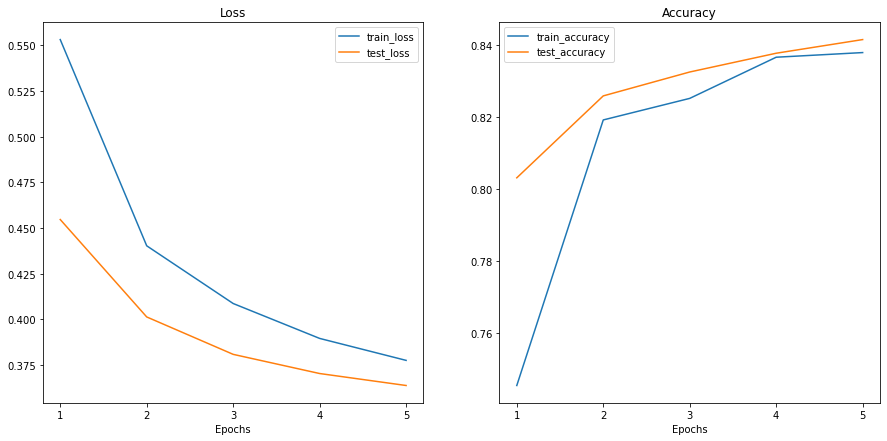

In [29]:
# Plot the loss curves of our model
plot_loss_curves(results)

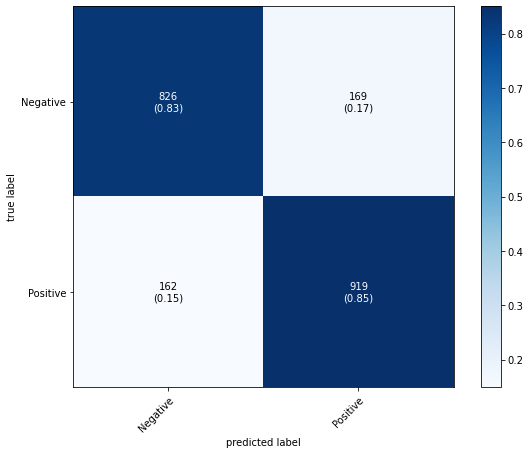

In [30]:
plot_confision_matrix(model, val_dataloader, 2)

# fine-tune pre-trained BERT

In [31]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.parameters():
    param.requires_grad = False

In [32]:
model.bert.encoder.layer[11]

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [33]:
# unfreeze the lasr layer of pre-trained BERT
for param in model.bert.encoder.layer[11].parameters(): # unfreeze linear layer
    param.requires_grad = True

In [34]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
set_seeds()
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

train 1 completed
test 1 completed
Epoch: 1 | train_loss: 0.5008 | train_acc: 0.8178 | test_loss: 0.3216 | test_acc: 0.8603 | time (sec): 146.39
train 2 completed
test 2 completed
Epoch: 2 | train_loss: 0.3083 | train_acc: 0.8712 | test_loss: 0.2855 | test_acc: 0.8762 | time (sec): 146.41
train 3 completed
test 3 completed
Epoch: 3 | train_loss: 0.2669 | train_acc: 0.8856 | test_loss: 0.3358 | test_acc: 0.8624 | time (sec): 146.57
train 4 completed
test 4 completed
Epoch: 4 | train_loss: 0.2445 | train_acc: 0.8931 | test_loss: 0.3279 | test_acc: 0.8663 | time (sec): 146.64
train 5 completed
test 5 completed
Epoch: 5 | train_loss: 0.2265 | train_acc: 0.9035 | test_loss: 0.3132 | test_acc: 0.8858 | time (sec): 146.54


average train accuracy: 0.8742486543062201
average test accuracy: 0.8701704545454545


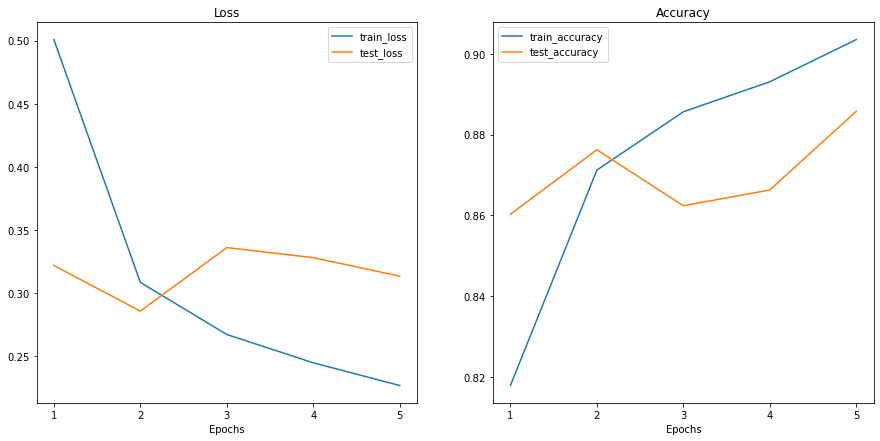

In [35]:
# Plot the loss curves of our model
plot_loss_curves(results)

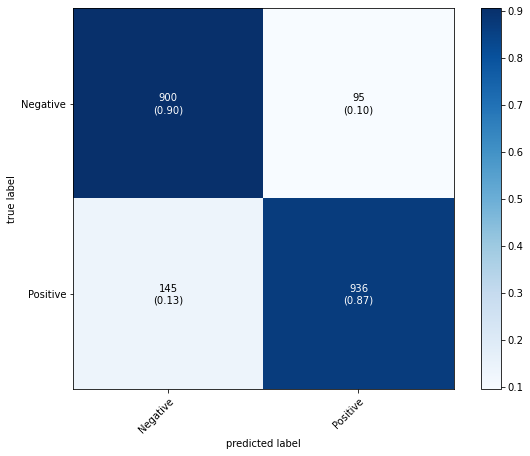

In [36]:
plot_confision_matrix(model, val_dataloader, 2)